In [25]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [26]:
df = pd.read_csv('Cleaned_Economic_News_Relabeled.csv')
def preprocess_headline(headline):
    headline = headline.lower()
    headline = re.sub(r'\b\d+(\.\d+)?\b', '<NUMBER>', headline)
    headline = re.sub(r'\d+(\.\d+)?%', '<PERCENTAGE>', headline)
    
    headline = re.sub(r'\$\d+(\.\d+)?', '<CURRENCY>', headline)  
    headline = re.sub(r'\d{1,2}/\d{1,2}/\d{2,4}', '<DATE>', headline)  

    headline = re.sub(r'[^\w\s\.,!?\'":;()-]', '', headline)

    headline = re.sub(r'\s+', ' ', headline).strip()
    
    return headline

In [27]:
df['cleaned_headline'] = df['headline'].apply(preprocess_headline)
X = df['cleaned_headline']  
y = df['sentiment']  

In [28]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [29]:
max_features_options = [5000, 10000, 20000]
ngram_range_options = [(1, 1), (1, 2), (1, 3)]
C_values = [0.1, 1, 10]


In [30]:

results = []

for max_features in max_features_options:
    for ngram_range in ngram_range_options:
        for C in C_values:
            print(f"Testing max_features={max_features}, ngram_range={ngram_range}, C={C}")
            
            # Vectorizer with current hyperparameters
            vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range, stop_words='english')
            X_train_tfidf = vectorizer.fit_transform(X_train)
            X_test_tfidf = vectorizer.transform(X_test)
            
            # Logistic Regression with current hyperparameters
            model = LogisticRegression(max_iter=5000, random_state=42, C=C)
            model.fit(X_train_tfidf, y_train)
            y_pred = model.predict(X_test_tfidf)
            
            # Accuracy calculation
            acc = accuracy_score(y_test, y_pred)
            print(f"Accuracy: {acc}\n")
            
            # Store results
            results.append({
                'max_features': max_features,
                'ngram_range': ngram_range,
                'C': C,
                'accuracy': acc
            })

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results)
results_df.sort_values(by='accuracy', ascending=False, inplace=True)

Testing max_features=5000, ngram_range=(1, 1), C=0.1
Accuracy: 0.4894366197183099

Testing max_features=5000, ngram_range=(1, 1), C=1
Accuracy: 0.545774647887324

Testing max_features=5000, ngram_range=(1, 1), C=10
Accuracy: 0.5316901408450704

Testing max_features=5000, ngram_range=(1, 2), C=0.1
Accuracy: 0.4823943661971831

Testing max_features=5000, ngram_range=(1, 2), C=1
Accuracy: 0.5387323943661971

Testing max_features=5000, ngram_range=(1, 2), C=10
Accuracy: 0.5176056338028169

Testing max_features=5000, ngram_range=(1, 3), C=0.1
Accuracy: 0.4859154929577465

Testing max_features=5000, ngram_range=(1, 3), C=1
Accuracy: 0.5528169014084507

Testing max_features=5000, ngram_range=(1, 3), C=10
Accuracy: 0.5

Testing max_features=10000, ngram_range=(1, 1), C=0.1
Accuracy: 0.4894366197183099

Testing max_features=10000, ngram_range=(1, 1), C=1
Accuracy: 0.545774647887324

Testing max_features=10000, ngram_range=(1, 1), C=10
Accuracy: 0.5316901408450704

Testing max_features=10000, ng

In [31]:
print("Top Hyperparameter Results:")
print(results_df.head())

# Plot confusion matrix for the best model
best_params = results_df.iloc[0]
print("Best Parameters:", best_params)

Top Hyperparameter Results:
    max_features ngram_range     C  accuracy
25         20000      (1, 3)   1.0  0.570423
26         20000      (1, 3)  10.0  0.559859
23         20000      (1, 2)  10.0  0.559859
14         10000      (1, 2)  10.0  0.559859
7           5000      (1, 3)   1.0  0.552817
Best Parameters: max_features       20000
ngram_range       (1, 3)
C                    1.0
accuracy        0.570423
Name: 25, dtype: object


In [32]:
vectorizer = TfidfVectorizer(max_features=int(best_params['max_features']), 
                             ngram_range=best_params['ngram_range'], 
                             stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [33]:
model = LogisticRegression(max_iter=5000, random_state=42)
model.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=5000, random_state=42)

In [34]:
y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.5704225352112676

Classification Report:
               precision    recall  f1-score   support

          -1       0.51      0.75      0.61       110
           0       0.94      0.35      0.50        84
           1       0.55      0.57      0.56        90

    accuracy                           0.57       284
   macro avg       0.67      0.55      0.56       284
weighted avg       0.65      0.57      0.56       284



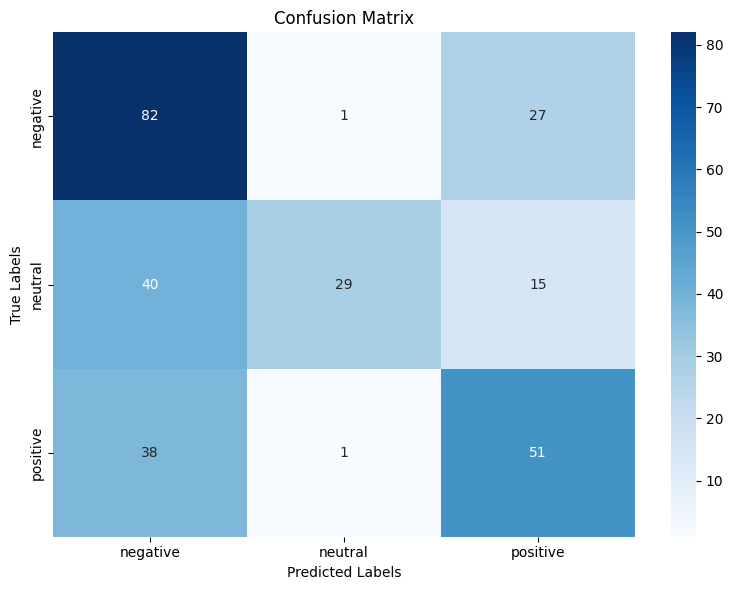

In [35]:

conf_matrix = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()
